In [ ]:
!pip install tokenizers
!pip install torchdata

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

from typing import Tuple
from torch import Tensor
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

In [3]:
'''Hyperparameters'''

''' Data Parameters '''
MAX_LEN = 64
VOCAB_SIZE = 32768
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
BATCH_SIZE = 128
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
''' Model Parameters '''
D_MODEL = 512
D_H = 8
D_FF = 2048
EMBEDDING_SIZE = 512
N = 3
''' Training Parameters '''
DROPOUT = 0.1
LR = 0.0001
BETAS = (0.9, 0.98)
EPS = 1e-9
EPOCHS = 15
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

f = open("parallelcorpus.txt", "a")

for i in train_iter:
  for x in [x.rstrip("\n") for x in i]:
    f.write(x)
    f.write(' ')

f.close()

In [5]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train(['parallelcorpus.txt'], trainer)

tokenizer.enable_padding(pad_id=1, length=MAX_LEN)
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_enc = tokenizer.encode(src_sample.rstrip("\n"))
        src_batch.append(torch.tensor(src_enc.ids))

        tgt_enc = tokenizer.encode(tgt_sample.rstrip("\n"))
        tgt_batch.append(torch.tensor(tgt_enc.ids))
    return torch.stack(src_batch), torch.stack(tgt_batch)

In [6]:
test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)

In [7]:
class Embedding(nn.Module):
    def __init__(self, vocab_size=32678, embedding_size=512, pad_mask=1):
        super(Embedding, self).__init__()
        self.embedding_size = embedding_size
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, padding_idx=pad_mask, device=DEVICE)

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.embedding_size)

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.d_h = d_h
        self.d_k = d_model // d_h
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)])
        self.dropout = nn.Dropout(dropout)
        self.Linear = nn.Linear(d_model, d_model)
        self.normalize1 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.normalize2 = nn.LayerNorm(d_model)

    def forward(self, x, x_mask=None):
        multi_head = []
        for i in range(self.d_h):
            query = self.linears[3*i](x)
            key = self.linears[3*i + 1](x)
            value = self.linears[3*i + 2](x)
            scaledDotProd = (query @ key.transpose(-1, -2)) / math.sqrt(self.d_k)
            if x_mask is not None:
                scaledDotProd = scaledDotProd.masked_fill(x_mask==0, float('-inf'))
            soft = F.softmax(scaledDotProd, dim=-1)
            soft = self.dropout(soft)
            attn =  soft @ value
            multi_head.append(attn)
        selfAttn = self.Linear(torch.cat((multi_head), -1))
        addNorm = self.normalize1(x + selfAttn)
        encoderOutput = self.normalize2(x + self.feed_forward(addNorm))
        return encoderOutput

In [9]:
class EncoderStack(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, 
                 dropout=0.1, N=6):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList([EncoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Encoder Layer N Times

    def forward(self, x, x_mask=None):
        for encoder in self.encoders:
            x = encoder(x, x_mask)
        return x

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.d_h = d_h
        self.d_k = d_model // d_h
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)])
        self.dropout1 = nn.Dropout(dropout)
        self.firstLinear = nn.Linear(d_h * self.d_k, d_model)
        self.normalize1 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.secondLinear = nn.Linear(d_h * d_model, d_model)
        self.normalize2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.normalize3 = nn.LayerNorm(d_model)

    def forward(self, x, y, y_mask=None):
        multi_head1 = []
        multi_head2 = []

        # FIRST ATTENTION LAYER
        ''' Same as encoder, but here we have tgt(target) as the decoder's input '''
        for i in range(self.d_h):
            query = self.linears[3*i](y)
            key = self.linears[3*i+1](y)
            value = self.linears[3*i+2](y)
            scaledDotProd = (query @ key.transpose(-1, -2)) / math.sqrt(self.d_k)
            if y_mask is not None:
                scaledDotProd = scaledDotProd.masked_fill(y_mask==0, float('-inf'))
            soft = F.softmax(scaledDotProd, dim=-1)
            soft = self.dropout1(soft)
            attn =  soft @ value
            multi_head1.append(attn)
        selfAttn = self.firstLinear(torch.cat((multi_head1), dim=-1))
        addNorm1 = self.normalize1(y + selfAttn)

        # SECOND ATTENTION LAYER
        ''' Attention layer, instead of V and K matrices, we use the output of the encoder '''
        for i in range(self.d_h):
            scaledDotProd = (addNorm1 @ x.transpose(-1, -2)) / math.sqrt(self.d_k)
            soft = F.softmax(scaledDotProd, dim=-1)
            soft = self.dropout2(soft)
            attn = soft @ x
            multi_head2.append(attn)
        crossAttn = self.secondLinear(torch.cat((multi_head2), dim=-1))
        addNorm2 = self.normalize2(y + crossAttn)
        decoderOutput = self.normalize3(y + self.feed_forward(addNorm2))
        return decoderOutput

In [11]:
class DecoderStack(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, 
                 dropout=0.1, N=6):
        super(DecoderStack, self).__init__()
        self.decoders = nn.ModuleList([DecoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Decoder Layer N Times

    def forward(self, x, y, y_mask=None):
        for decoder in self.decoders:
            y = decoder(x, y, y_mask)
        return y

In [12]:
class Mask(nn.Module):
    def __init__(self):
        super(Mask, self).__init__()
    
    def forward(self, batch_dim, seq_len):
        mask = torch.tril(torch.ones((batch_dim, seq_len, seq_len), device=DEVICE))
        return mask

In [13]:
class Positional_Encoding(nn.Module):
    def __init__(self, embedding_size=512, n=10000):
        super(Positional_Encoding, self).__init__()
        self.embedding_size = embedding_size
        self.n = n
    def forward(self, seq_len):
        P = torch.zeros(seq_len, self.embedding_size, device=DEVICE)
        for k in range(seq_len):
            for i in range(self.embedding_size // 2):
                denominator = math.pow(self.n, 2*i/self.embedding_size)
                P[k, 2*i] = math.sin(k/denominator)
                P[k, 2*i+1] = math.cos(k/denominator)
        return P

In [14]:
class GenerateLogits(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(GenerateLogits, self).__init__()
        self.linear = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        return self.linear(x)

In [15]:
class Transformer(nn.Module):
    def __init__(self, d_model=512, d_h = 8, d_ff=2048, 
                 embedding_size=512, vocab_size=32768, 
                 dropout=0.1, num_coder_layers=6):
        super(Transformer, self).__init__()
        self.embed = Embedding(vocab_size, embedding_size, pad_mask=1)
        self.positional = Positional_Encoding(embedding_size, 10000)
        self.masking = Mask()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.encoderStack = EncoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)
        self.decoderStack = DecoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)
        self.generate = GenerateLogits(d_model, vocab_size)

    def forward(self, x: Tensor, y: Tensor):
        assert x.shape[0] == y.shape[0]
        batch_dim = x.shape[0]
        src_seq_len, tgt_seq_len = x.shape[1], y.shape[1]
        x_pos_encoding = self.positional(src_seq_len)
        y_pos_encoding = self.positional(tgt_seq_len)
        x_mask = self.masking(batch_dim, src_seq_len)
        y_mask = self.masking(batch_dim, tgt_seq_len)
        x, y = self.embed(x), self.embed(y)
        x, y = x_pos_encoding + x, y_pos_encoding + y
        x, y = self.dropout1(x), self.dropout2(y)
        encoderOutput = self.encoderStack(x, x_mask)
        decoderOutput = self.decoderStack(encoderOutput, y, y_mask)
        logits = self.generate(decoderOutput)
        return logits

In [16]:
model = Transformer(d_model=D_MODEL, d_h=D_H, d_ff=D_FF, 
                    embedding_size=EMBEDDING_SIZE, 
                    vocab_size=VOCAB_SIZE, dropout=DROPOUT, 
                    num_coder_layers=N)
model = model.to(DEVICE)

# Training the model:

In [ ]:
torch.manual_seed(0)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
@torch.no_grad()
def compute_test_loss(model: nn.Module, test_data: DataLoader, 
                      padding_index: int):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=padding_index)
    loss = []
    for src, tgt in test_data:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_in = tgt[:, :-1] # inputs shifted left
        tgt_out = tgt[:, 1:] # labels shifted right
        logits = model(src, tgt_in).permute(0, 2, 1)
        loss.append(criterion(logits, tgt_out).item())
    average_loss = np.average(loss)
    model.train()
    return average_loss

In [ ]:
def train(model: nn.Module, train_data: DataLoader, 
          test_data: DataLoader, learning_rate: int, 
          padding_idx: int, epoch_num: int, betas: Tuple, eps: int):
    
    model.train()

    criterion = nn.CrossEntropyLoss(ignore_index=padding_idx)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, eps=eps)
    batch_train_loss = []
    epoch_test_loss = []

    for epoch in range(0, epoch_num):
        print("#"*67)
        print(f'{"#"*20}Training begins for epoc {epoch:>2}{"#"*20}')
        print("#"*67)
        epoch_train_loss = []
        for _, (src, tgt) in enumerate(train_data):
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            tgt_in = tgt[:, :-1] # inputs shifted left
            
            logits = model(src, tgt_in).permute(0, 2, 1)
            optimizer.zero_grad()
            
            tgt_out = tgt[:, 1:] # labels shifted right
            loss = criterion(logits, tgt_out)
            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())
            batch_train_loss.append(loss.item())
    
        ep_train_loss = np.average(epoch_train_loss)
        print(f'Training is complete for epoch {epoch:>2}, average training loss for epoch {epoch:>2}: {ep_train_loss:>5.3f}')
        test_loss = compute_test_loss(model, test_data, padding_idx)
        print(f'Test loss for epoch {epoch:>2}: {test_loss:>5.3f}')
        epoch_test_loss.append(test_loss)
        print("-"*67)
    plt.plot(batch_train_loss, color='blue')
    plt.title("Batch Loss Graph")
    plt.xlabel("Hundred Batches")
    plt.ylabel("Loss per Batch")
    plt.show()

    plt.plot(epoch_test_loss, color='purple', label='Epoch Test Loss')
    plt.title("Epoch Test Loss Graph")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

###################################################################
####################Training begins for epoc  0####################
###################################################################
Training is complete for epoch  0, average training loss for epoch  0: 5.871
Test loss for epoch  0: 4.516
-------------------------------------------------------------------
###################################################################
####################Training begins for epoc  1####################
###################################################################
Training is complete for epoch  1, average training loss for epoch  1: 4.011
Test loss for epoch  1: 3.628
-------------------------------------------------------------------
###################################################################
####################Training begins for epoc  2####################
###################################################################
Training is complete for epoch  2, ave

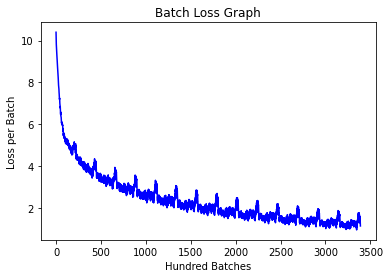

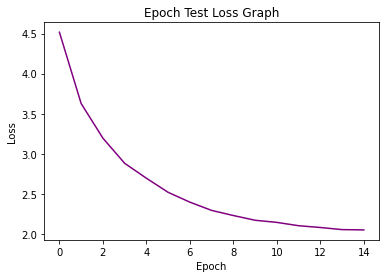

In [ ]:
train(model, train_dataloader, test_dataloader, 
      learning_rate=LR, padding_idx=PAD_IDX, 
      epoch_num=EPOCHS, betas=BETAS, eps=EPS)

# Model outputs on some of the examples from test set:

In [22]:
model.eval()
src, tgt = next(iter(test_dataloader))
src, tgt = src[:5].to(DEVICE), tgt[:5].to(DEVICE)
print(src.shape)
print(tgt.shape)

torch.Size([5, 64])
torch.Size([5, 64])


In [23]:
logits = model(src, tgt)
pred = torch.argmax(logits, dim=2)

In [24]:
for example in range(5):
    print(f"Example no {example}: ")
    '''pad_count = (tgt[example] == PAD_IDX).data.sum().item()
    sentence_len = tgt.shape[1] - pad_count'''
    print("#"*80)
    print("#German text: ", tokenizer.decode(src[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("#English translation: ", tokenizer.decode(tgt[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("#Model translation: ", tokenizer.decode(pred[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("\n")

Example no 0: 
################################################################################
#German text:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
################################################################################
#English translation:  A group of men are loading cotton onto a truck
################################################################################
#Model translation:  A group of men are putting laundry candy a truck . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
################################################################################


Example no 1: 
################################################################################
#German text:  Ein Mann schläft in einem grünen Raum auf einem Sofa .
################################################################################
#English translation:  A man sleeping in a green room on a couch .
#########################################################

# Translating a random German sentence from the test set using Greedy Decoding:

In [25]:
src, tgt = next(iter(test_dataloader))
src = src[:1]
tgt = tgt[:1]
print(src.shape)
print(tgt.shape)

torch.Size([1, 64])
torch.Size([1, 64])


In [28]:
@torch.no_grad()
def translate(model: nn.Module, source: Tensor, start_token: int, stop_token: int, seq_len: int):
    model.eval()

    source = source.to(DEVICE)
    src_batch_dim = source.shape[0]
    src_seq_len = source.shape[1]

    src_mask = model.masking(src_batch_dim, src_seq_len)
    src_pos_enc = model.positional(src_seq_len)
    src_embedding = model.embed(source)

    encoderInput = src_embedding + src_pos_enc

    encoderOutput = model.encoderStack(encoderInput, src_mask)

    ys = torch.tensor([[start_token]], dtype=torch.int32, device=DEVICE)

    for _ in range(seq_len):

        tgt_batch_dim = ys.shape[0]
        tgt_seq_len = ys.shape[1]

        embedded_sequence = model.embed(ys)
        seq_pos_enc = model.positional(tgt_seq_len)
        decoder_mask = model.masking(tgt_batch_dim, tgt_seq_len)

        decoderInput = embedded_sequence + seq_pos_enc
    
        out = model.decoderStack(encoderOutput, decoderInput, decoder_mask)

        logits = model.generate(out[:, -1, :])
        generated_word_id = torch.argmax(logits, dim=-1)

        ys = torch.cat((ys, torch.tensor([[generated_word_id.item()]], 
                                                     dtype=torch.int32, device=DEVICE)), dim=1)

        if generated_word_id == stop_token:
            break

    translation_ids = ys.cpu().numpy()

    translation = tokenizer.decode(translation_ids.squeeze())
    return translation

translation = translate(model=model, source=src, start_token=BOS_IDX, stop_token=EOS_IDX, seq_len=MAX_LEN)
english = tokenizer.decode(tgt.to(DEVICE).numpy().squeeze())
print(english)
print(translation)

A group of men are loading cotton onto a truck
A group of men are putting bubbles on a truck .


# Translating a given German sentence:

In [30]:
english = "A happy dog is playing with a toy."
german = "Ein glücklicher Hund spielt mit einem Spielzeug."
encoded_german = tokenizer.encode(german)
german_id_arr = encoded_german.ids

tgt_input = torch.tensor(german_id_arr).unsqueeze(0)

translation = translate(model, tgt_input, 2, 3, MAX_LEN)
print("German: ", german)
print("English: ", english)
print("Model translation: ", translation)

German:  Ein glücklicher Hund spielt mit einem Spielzeug.
English:  A happy dog is playing with a toy.
Model translation:  A happy dog is playing with a toy .
